In [1]:
# Import necessary libraries
import numpy as np 
import pandas as pd 
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import os
from PIL import Image, ImageFile
import warnings

# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", Image.DecompressionBombWarning)


In [2]:
# Define dataset path
data_dir = '/kaggle/input/ai-generated-images-vs-real-images/train'

# Image processing functions
Image.MAX_IMAGE_PIXELS = None

def convert_to_rgb(image):
    if image.mode == 'P':
        image = image.convert("RGBA")
    if image.mode == "RGBA":
        background = Image.new("RGB", image.size, (255, 255, 255))
        image = Image.alpha_composite(background, image).convert("RGB")
    elif image.mode != "RGB":
        image = image.convert("RGB")
    return image

def resize_large_image(image, max_size):
    if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
        image.thumbnail(max_size, Image.Resampling.LANCZOS)
    return image

# Define transformations
train_transform = transforms.Compose([
    transforms.Lambda(lambda img: resize_large_image(img, max_size=(5000, 5000))),
    transforms.Lambda(convert_to_rgb),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Lambda(convert_to_rgb),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

ImageFile.LOAD_TRUNCATED_IMAGES = True
MIN_IMAGE_FILE_SIZE = 3284

def is_valid_image(file_path):
    try:
        if os.path.getsize(file_path) < MIN_IMAGE_FILE_SIZE:
            return False
        with Image.open(file_path) as img:
            img.verify()
        return True
    except (OSError, Image.DecompressionBombError):
        return False

class ValidImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        self.samples = [(path, label) for path, label in self.samples if is_valid_image(path)]
        self.targets = [label for _, label in self.samples]

# Load dataset
dataset = ValidImageFolder(root=data_dir, transform=train_transform)

In [3]:
from torch.utils.data import Subset

fake_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == dataset.class_to_idx['fake']]
real_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == dataset.class_to_idx['real']]

fake_subset_size = int(1.0/2.0 * len(fake_indices))
real_subset_size = int(1.0/2.0 * len(real_indices))

fake_subset_indices = fake_indices[0:fake_subset_size]
real_subset_indices = real_indices[0:real_subset_size]

balanced_subset_indices = np.concatenate((fake_subset_indices, real_subset_indices))
balanced_subset = Subset(dataset, balanced_subset_indices)

print(f"Original Dataset Size: {len(dataset)}")
print(f"Balanced Subset Size: {len(balanced_subset)} (Fake: {fake_subset_size}, Real: {real_subset_size})")

Original Dataset Size: 47998
Balanced Subset Size: 23999 (Fake: 12000, Real: 11999)


In [4]:
train_size = int(0.8 * len(balanced_subset))
val_size = len(balanced_subset) - train_size
train_dataset, val_dataset = random_split(balanced_subset, [train_size, val_size])

val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [5]:
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")

Train Dataset Size: 19199
Validation Dataset Size: 4800


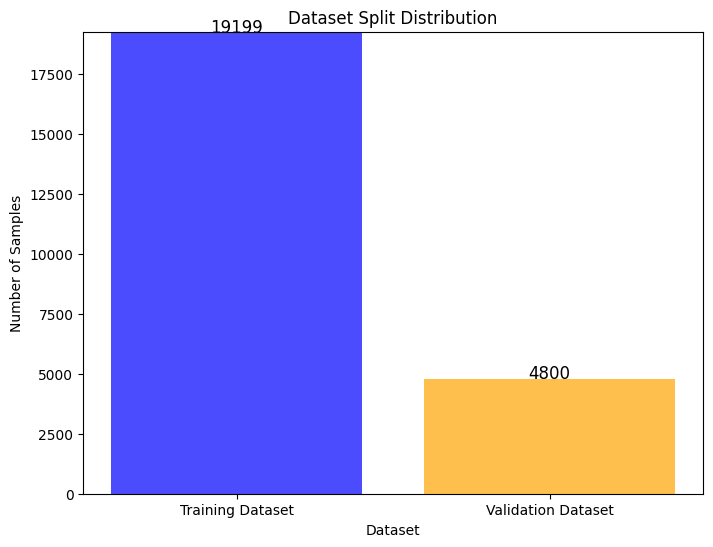

In [6]:
import matplotlib.pyplot as plt

train_size = len(train_dataset)
val_size = len(val_dataset)

labels = ['Training Dataset', 'Validation Dataset']
sizes = [train_size, val_size]

plt.figure(figsize=(8, 6))
plt.bar(labels, sizes, color=['blue', 'orange'], alpha=0.7)

for i, size in enumerate(sizes):
    plt.text(i, size + 5, str(size), ha='center', fontsize=12)

plt.title('Dataset Split Distribution')
plt.ylabel('Number of Samples')
plt.xlabel('Dataset')
plt.ylim(0, max(sizes) + 50)
plt.show()

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
import torchvision.models as models

model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)

# Modify the classifier layer to match the number of classes (e.g., 2 for binary classification)
num_ftrs = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_ftrs, 2)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 117MB/s]


In [9]:
from torch.optim.lr_scheduler import StepLR

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [10]:
# Training and validation loop
patience = 6
trigger_times = 0
best_val_loss = float('inf')
epochs = 8
best_val_acc = 0.0

data = {
    "train_losses": [],
    "train_accuracies": [],
    "val_losses": [],
    "val_accuracies": [],
}

In [11]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    data["train_losses"].append(epoch_loss)
    data["train_accuracies"].append(epoch_acc.item())

    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

            # Store predictions and labels for metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)

    data["val_losses"].append(val_loss)
    data["val_accuracies"].append(val_acc.item())

    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Precision, Recall, F1-Score
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

    if val_acc > best_val_acc:
        best_val_acc = val_acc

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'best_model{epoch}_mobilenetv3_small.pth')
        trigger_times = 0  # Reset early stopping counter
    else:
        trigger_times += 1
        print(f"Early stopping trigger count: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping...")
            break

    # Step the scheduler
    scheduler.step()

print(f'Best Validation Accuracy: {best_val_acc:.4f}')
print(f'Best Validation Loss: {best_val_loss:.4f}')

Epoch 1/8


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.3196 Acc: 0.8642
Val Loss: 0.4147 Acc: 0.8446

Classification Report:
              precision    recall  f1-score   support

        fake       0.78      0.95      0.86      2385
        real       0.94      0.74      0.83      2415

    accuracy                           0.84      4800
   macro avg       0.86      0.85      0.84      4800
weighted avg       0.86      0.84      0.84      4800

Epoch 2/8


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2521 Acc: 0.8953
Val Loss: 0.4088 Acc: 0.8306

Classification Report:
              precision    recall  f1-score   support

        fake       0.76      0.97      0.85      2385
        real       0.96      0.70      0.81      2415

    accuracy                           0.83      4800
   macro avg       0.86      0.83      0.83      4800
weighted avg       0.86      0.83      0.83      4800

Epoch 3/8


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2255 Acc: 0.9118
Val Loss: 0.2834 Acc: 0.8946

Classification Report:
              precision    recall  f1-score   support

        fake       0.90      0.89      0.89      2385
        real       0.89      0.90      0.90      2415

    accuracy                           0.89      4800
   macro avg       0.89      0.89      0.89      4800
weighted avg       0.89      0.89      0.89      4800

Epoch 4/8


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.1748 Acc: 0.9331
Val Loss: 0.2061 Acc: 0.9158

Classification Report:
              precision    recall  f1-score   support

        fake       0.91      0.92      0.92      2385
        real       0.92      0.91      0.92      2415

    accuracy                           0.92      4800
   macro avg       0.92      0.92      0.92      4800
weighted avg       0.92      0.92      0.92      4800

Epoch 5/8


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.1495 Acc: 0.9432
Val Loss: 0.1718 Acc: 0.9346

Classification Report:
              precision    recall  f1-score   support

        fake       0.94      0.92      0.93      2385
        real       0.93      0.94      0.94      2415

    accuracy                           0.93      4800
   macro avg       0.93      0.93      0.93      4800
weighted avg       0.93      0.93      0.93      4800

Epoch 6/8


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.1373 Acc: 0.9468
Val Loss: 0.1818 Acc: 0.9277

Classification Report:
              precision    recall  f1-score   support

        fake       0.95      0.90      0.93      2385
        real       0.91      0.96      0.93      2415

    accuracy                           0.93      4800
   macro avg       0.93      0.93      0.93      4800
weighted avg       0.93      0.93      0.93      4800

Early stopping trigger count: 1/6
Epoch 7/8


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.1254 Acc: 0.9509
Val Loss: 0.1819 Acc: 0.9290

Classification Report:
              precision    recall  f1-score   support

        fake       0.95      0.91      0.93      2385
        real       0.91      0.95      0.93      2415

    accuracy                           0.93      4800
   macro avg       0.93      0.93      0.93      4800
weighted avg       0.93      0.93      0.93      4800

Early stopping trigger count: 2/6
Epoch 8/8


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.1279 Acc: 0.9519
Val Loss: 0.1780 Acc: 0.9329

Classification Report:
              precision    recall  f1-score   support

        fake       0.95      0.92      0.93      2385
        real       0.92      0.95      0.93      2415

    accuracy                           0.93      4800
   macro avg       0.93      0.93      0.93      4800
weighted avg       0.93      0.93      0.93      4800

Early stopping trigger count: 3/6
Best Validation Accuracy: 0.9346
Best Validation Loss: 0.1718


In [12]:
df = pd.DataFrame(data)

In [13]:
print(data)

{'train_losses': [0.3195958341047834, 0.2520596761664125, 0.2254724443390367, 0.17479064483863996, 0.1494635780279298, 0.13730650843416095, 0.1253788004011262, 0.12791838731008046], 'train_accuracies': [0.8642116776915464, 0.8953070472420438, 0.9118183238710349, 0.9330694306995155, 0.9432262096984217, 0.9468201468826501, 0.9508828584822125, 0.9518724933590291], 'val_losses': [0.4147257816791534, 0.4087573421001434, 0.2834275929133097, 0.20613828281561533, 0.17184990664323171, 0.18184383153915407, 0.18188028593858083, 0.1779590258995692], 'val_accuracies': [0.8445833333333334, 0.8306250000000001, 0.8945833333333334, 0.9158333333333334, 0.9345833333333334, 0.9277083333333334, 0.9289583333333334, 0.9329166666666667]}


In [14]:
df

,train_losses,train_accuracies,val_losses,val_accuracies
0,0.319596,0.864212,0.414726,0.844583
1,0.252060,0.895307,0.408757,0.830625
2,0.225472,0.911818,0.283428,0.894583
3,0.174791,0.933069,0.206138,0.915833
4,0.149464,0.943226,0.171850,0.934583
5,0.137307,0.946820,0.181844,0.927708
6,0.125379,0.950883,0.181880,0.928958
7,0.127918,0.951872,0.177959,0.932917


In [15]:
df.to_csv("/kaggle/working/MobileNet_2-3ofData.csv", index=False)
print("CSV file saved successfully!")

CSV file saved successfully!


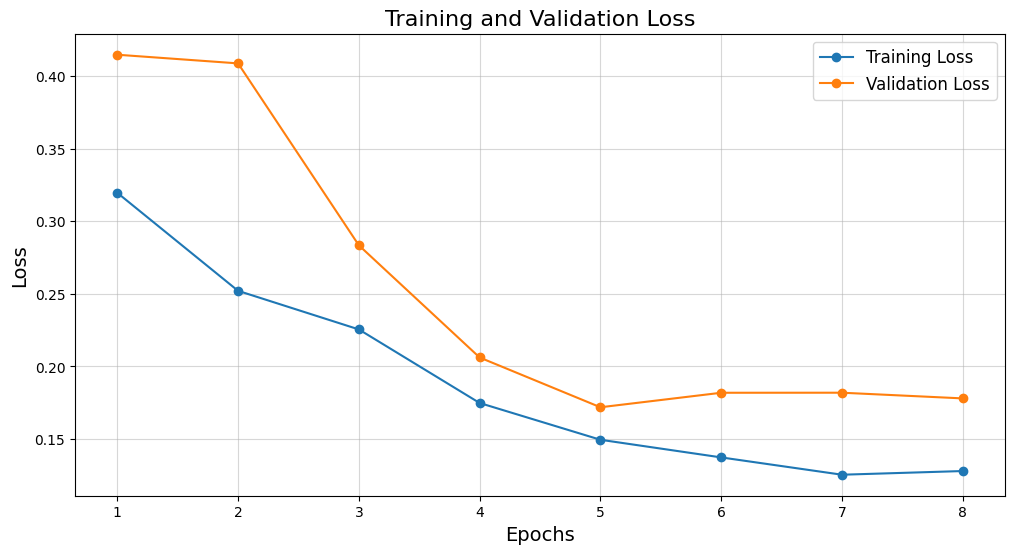

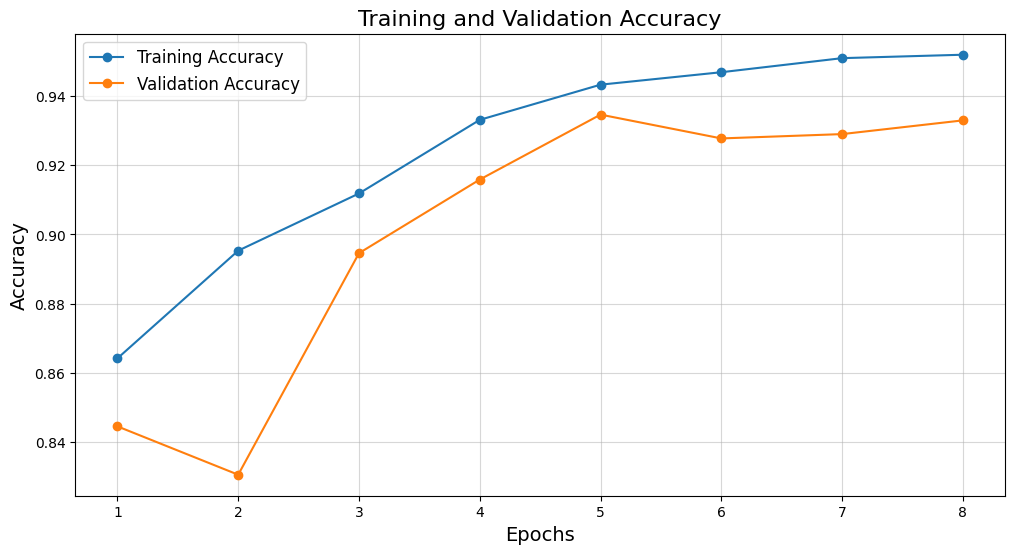

In [16]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(data["train_losses"]) + 1), data["train_losses"], label='Training Loss', marker='o')
plt.plot(range(1, len(data["val_losses"]) + 1), data["val_losses"], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(range(1, len(data["train_losses"]) + 1))
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(data["train_accuracies"]) + 1), data["train_accuracies"], label='Training Accuracy', marker='o')
plt.plot(range(1, len(data["val_accuracies"]) + 1), data["val_accuracies"], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(range(1, len(data["train_accuracies"]) + 1))
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()